# Display

`plenoptic` contains a variety of code for visualizing the outputs and the process of synthesis. This notebook details how to make use of that code, which has largely been written with the following goals:
1. If you follow the model API (and that of `Synthesis`, if creating a new synthesis method), display code should plot something reasonably useful automatically.
2. The code is flexible enough to allow for customization for more useful visualizations.
3. If the plotting code works, the animate code should also.

In [1]:
import plenoptic as po
import matplotlib.pyplot as plt
import torch
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

## General

We include two wrappers of display code from `pyrtools`, adapting them for use with tensors. These `imshow` and `animshow`, which accept tensors of real- or complex-valued images or videos (respectively) and properly convert them to arrays for display purposes. These are not the most flexible functions (for example, `imshow` requires that real-valued tensors be 4d) but, assuming you follow our API, should work relatively painlessly. The main reason for using them (over the image-display code from `matplotlib`) is that we guarantee fidelity to image size: a value in the tensor corresponds to a pixel or an integer number of pixels in the image (if upsampling); if downsampling, we can only down-sample by factors of two. This way, you can be sure that any strange apperance of the image is not due to aliasing in the plotting.

For `imshow`, we require that real-valued tensors be 4d: `(batch, channel, height, width)`. If you're showing images, they're likely to be grayscale (in which case there's only 1 channel) or RGB(A) (in which case there's 3 or 4, depending on whether it includes the alpha channel). We plot grayscale images without a problem:

torch.Size([2, 1, 256, 256])


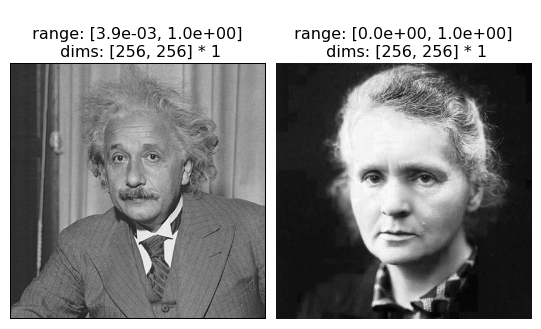

In [2]:
img = po.load_images(['../data/einstein.pgm', '../data/curie.pgm'])
print(img.shape)
fig = po.imshow(img)

We need to tell `imshow` that the image(s) are RGB in order for it to be plot correctly.

torch.Size([2, 3, 256, 256])


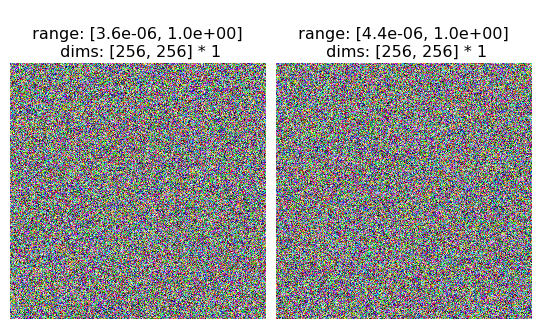

In [3]:
rgb = torch.rand(2, 3, 256, 256)
print(rgb.shape)
fig = po.imshow(rgb, as_rgb=True)

 This is because we don't want to assume that a tensor with 3 or 4 channels is always RGB. To pick a somewhat-contrived example, imagine the following steerable pyramid:

In [4]:
pyr = po.simul.Steerable_Pyramid_Freq(img.shape[-2:], downsample=False, height=1, order=2)

In [5]:
coeffs = pyr(img)
print(coeffs.shape)

torch.Size([2, 5, 256, 256])


The first and last channels are residuals, so if we only wanted to look at the coefficients, we'd do the following:

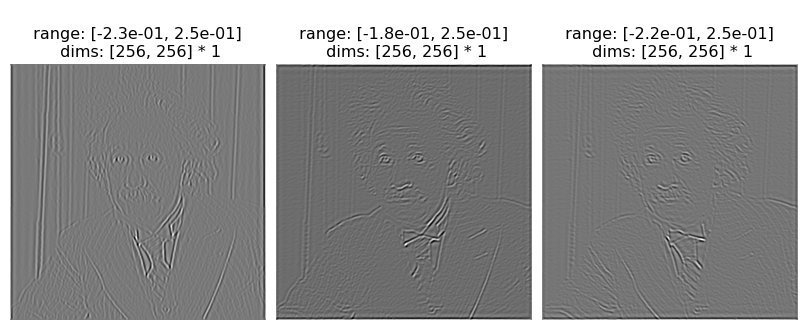

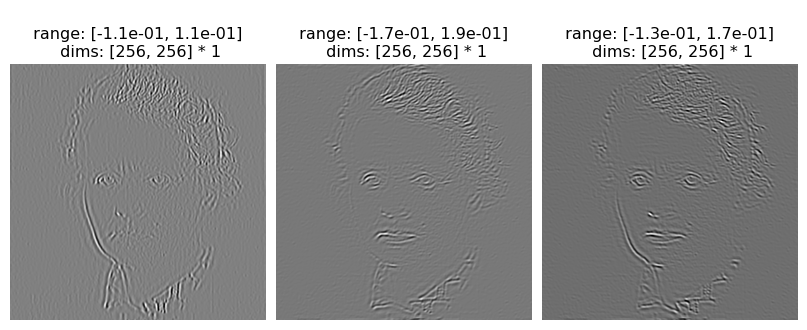

In [6]:
po.imshow(coeffs[:, 1:-1], batch_idx=0)
po.imshow(coeffs[:, 1:-1], batch_idx=1);

We really don't want to interpret those values as RGB.

Note that in the above `imshow` calls, we had to specify the `batch_idx`. This function expects a 4d tensor, but if it has more than one channel and more than one batch (and it's not RGB), we can't display everything. The user must therefore specify either `batch_idx` or `channel_idx`.

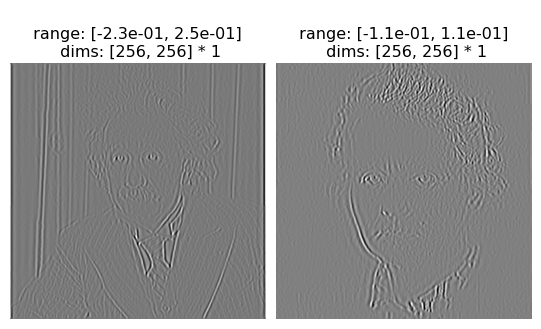

In [7]:
po.imshow(coeffs[:, 1:-1], channel_idx=0);

### COMPLEX TENSORS and PYRSHOW

after Nikhil makes the changes to steerable pyramid

`animshow` works analogously to `imshow`, wrapping around the `pyrtools` version but expecting a 5d tensor: `(batch, channel, time, height, width)`. It returns a `matplotlib.animation.FuncAnimation` object, which can be saved as an mp4 or converted to an html object for display in a Jupyter notebook

In [8]:
pyr = po.simul.Steerable_Pyramid_Freq(img.shape[-2:], downsample=False, height='auto', order=3)
coeffs = pyr(img)
print(coeffs.shape)
# because coeffs is 4d, we add a dummy dimension for the channel in order to make animshow happy
po.convert_anim_to_html(po.animshow(coeffs.unsqueeze(1), batch_idx=0))

torch.Size([2, 26, 256, 256])


## Synthesis-specific

Each synthesis method has a variety of display code to visualize the state and progress of synthesis, as well as to ease understanding of the process and look for ways to improve. For example, in metamer synthesis, it can be useful to determine what component of the model has the largest error.

In [9]:
img = po.load_images('../data/einstein.pgm')
lnl = po.simul.Linear_Nonlinear()
rep = lnl(img)

As long as your model returns a 3d or 4d vector (first two dimensions corresponding to `batch` and `channel`), then our plotting code should work automatically. If it returns a 3d representation, we plot a stem plot; if it's 4d, an image.

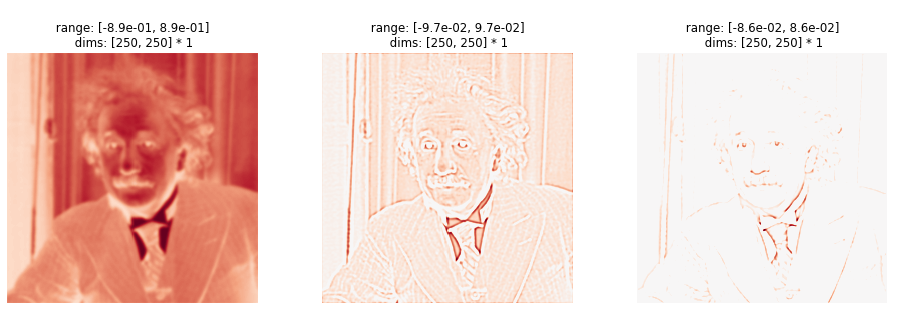

In [10]:
po.tools.display.plot_representation(data=rep, figsize=(16, 5));

This also gets used in the plotting code built into our synthesis methods.

In [11]:
met = po.synth.Metamer(img, lnl)
met.synthesize(max_iter=100, optimizer='Adam', store_progress=True, learning_rate=.1);

100%|██████████| 100/100 [00:05<00:00, 16.71it/s, gradient_norm=7.3268e-01, learning_rate=0.05, loss=7.7895e-01, pixel_change=1.4814e-02]


After we've run synthesis for a while, we want to investigate how close we are. We can examine the numbers printed out above, but it's probably useful to plot something. We provide the `plot_synthesis_status()` method for doing this. By default, it includes the synthesized image, the loss, and the representation error. That lost plot is the same as the one above, except it plots `data = base_representation - synthesized_representation`.

/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:880: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


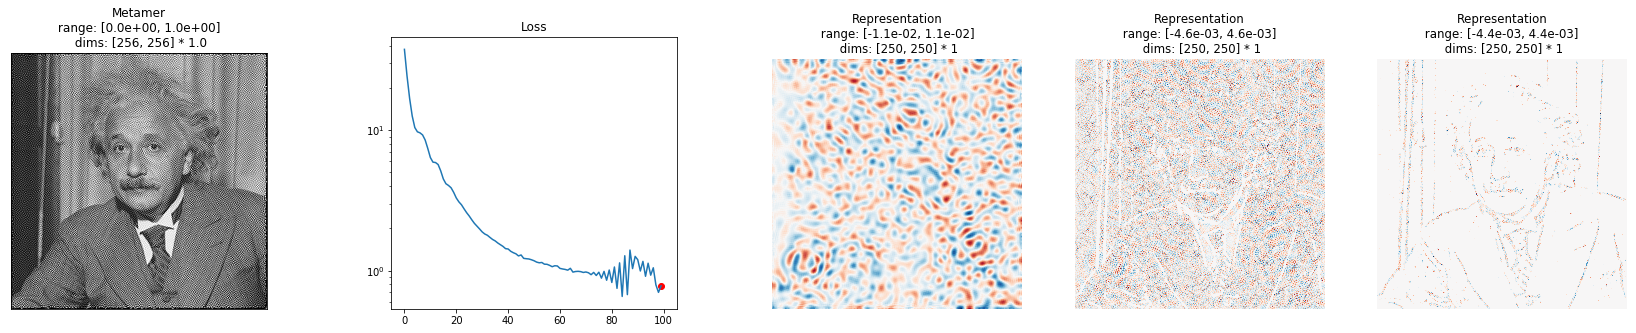

In [12]:
# we have three image plots for representation error, so that bit should be 3x wider
fig = met.plot_synthesis_status(width_ratios={'representation_error_width': 3})

You can also create this plot at different iterations, in order to try and better understand what's happening

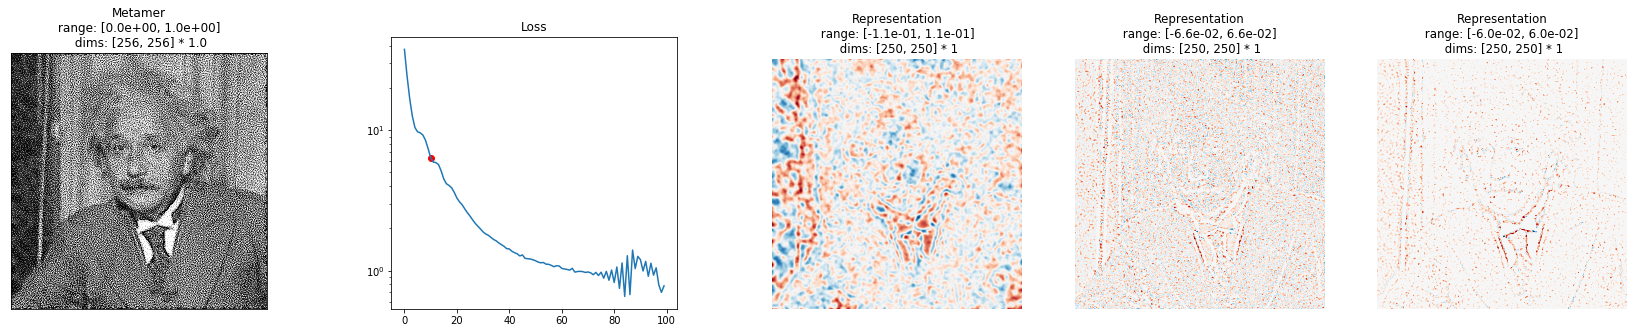

In [13]:
fig = met.plot_synthesis_status(iteration=10, width_ratios={'representation_error_width': 3})

The appearance of this figure is very customizable. There are many additional plots that can be included, and all plots are optional. The additional plots are: two histograms comparing the pixel values of the synthesized and base signal, a scatter plot comparing the base and synthesized representation, and a scatter plot comparing the two signals. You probably don't want all of these, but some subset might be helpful.

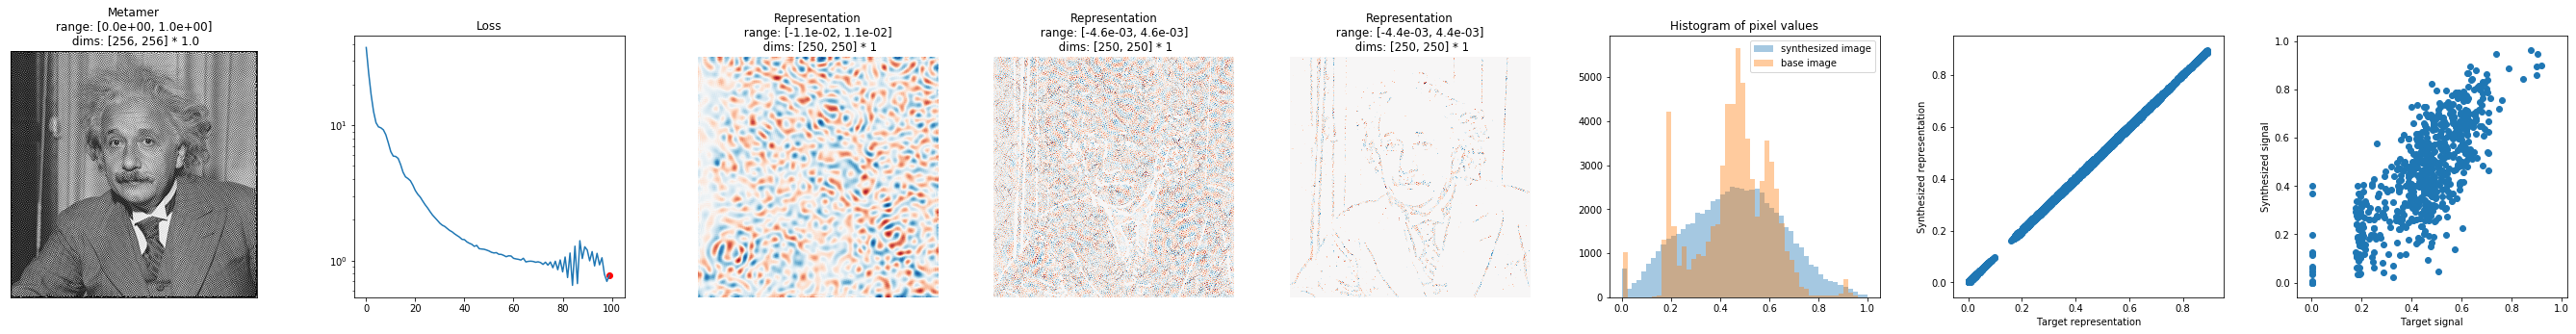

In [14]:
fig = met.plot_synthesis_status(plot_rep_comparison=True, plot_signal_comparison=True, plot_image_hist=True, width_ratios={'representation_error_width': 3.1})

In addition to being able to customize which plots to include, you can also pre-create the figure (with axes, if you'd like) and pass it in. By default, we try and create an appropriate-looking figure, with appropriately-sized plots, but this allows for more flexibility:

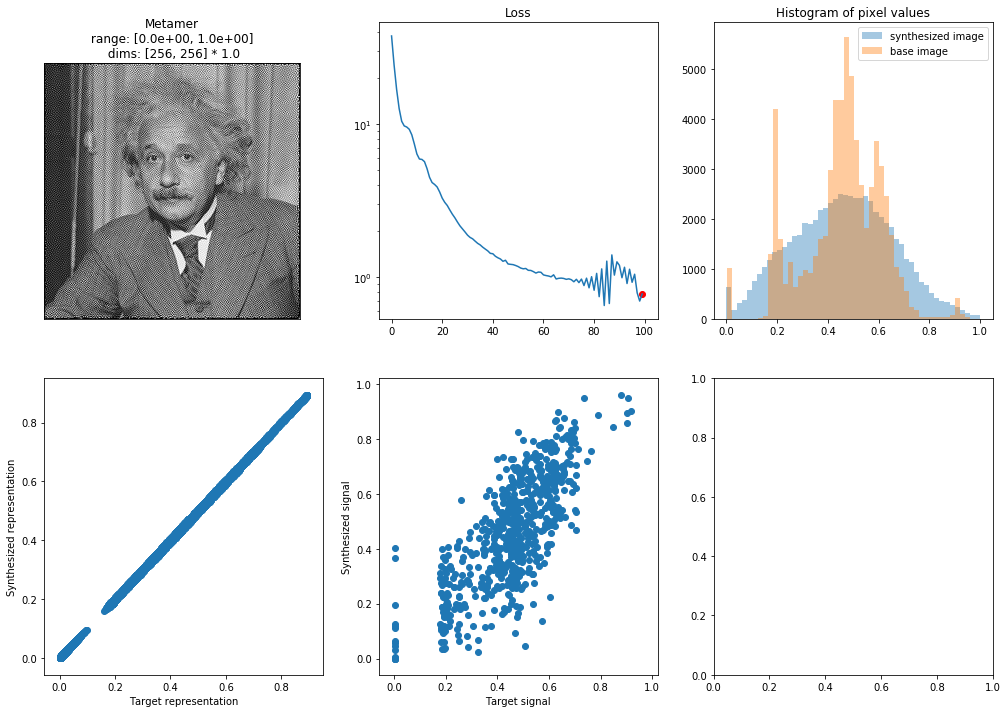

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(17, 12))
fig = met.plot_synthesis_status(plot_rep_comparison=True, plot_signal_comparison=True, plot_image_hist=True, fig=fig,
                                plot_representation_error=False)

For even more flexibility, you can specify which plot should go in which axes, by creating an `axes_idx` dictionary. Keys for each plot can be created, as well as a subset (in which case each plot gets added to the next available axes, like above when `axes_idx` is unset; see docstring for key names):

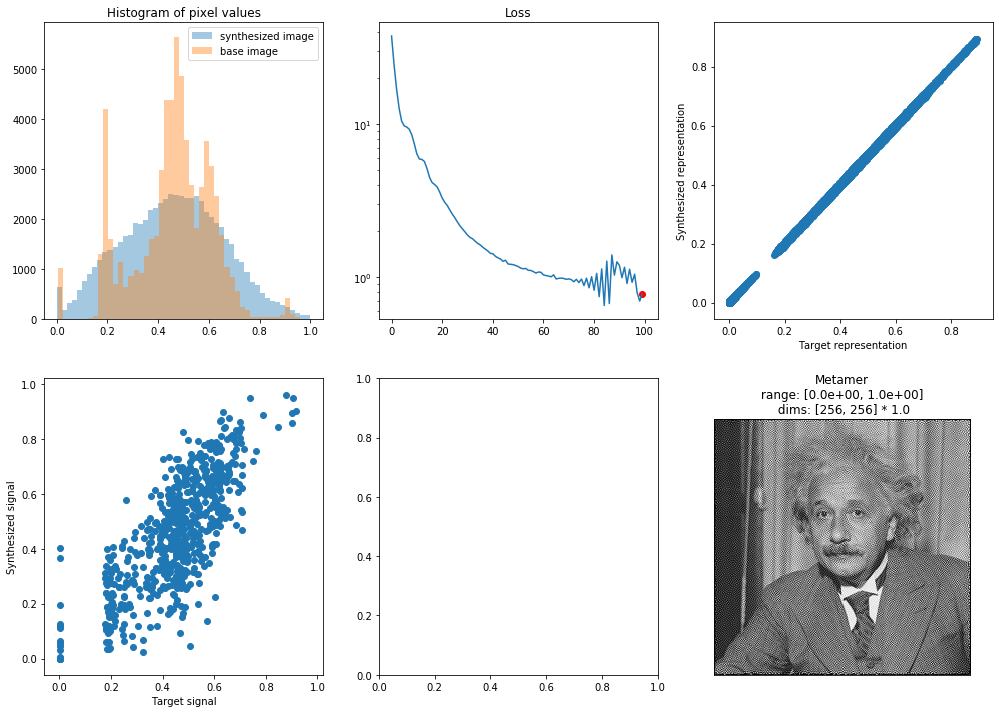

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(17, 12))
axes_idx = {'image': 5, 'hist': 0}
fig = met.plot_synthesis_status(plot_rep_comparison=True, plot_signal_comparison=True, plot_image_hist=True, 
                                fig=fig, axes_idx=axes_idx, plot_representation_error=False)

This allows enables you to create more complicated figures, with axes containing other plots, arrows and other annotations, etc. 

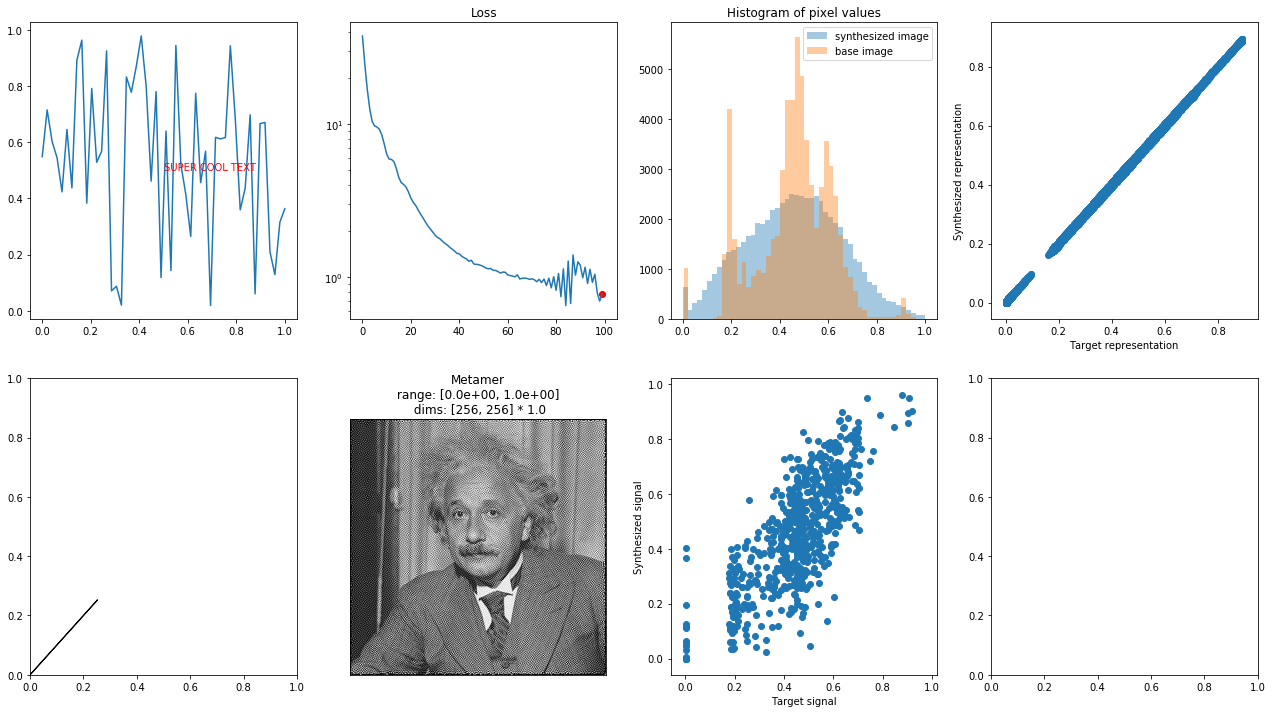

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(22, 12))
# to tell plot_synthesis_status to ignore plots, add them to the misc keys
axes_idx = {'image': 5, 'misc': [0, 4]}
axes[0, 0].text(.5, .5, 'SUPER COOL TEXT', color='r')
axes[1, 0].arrow(0, 0, .25, .25, )
axes[0, 0].plot(np.linspace(0, 1), np.random.rand(50))
fig = met.plot_synthesis_status(plot_rep_comparison=True, plot_signal_comparison=True, plot_image_hist=True, 
                                fig=fig, axes_idx=axes_idx, plot_representation_error=False)

Our synthesis methods also have an `animate` function, which animates the above plots over time, and everything that I said above also holds for them. Note that `animate` requires [ffmpeg](https://ffmpeg.org/download.html) on your system and will take a fair amount of time to run:

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(22, 12))
# to tell plot_synthesis_status to ignore plots, add them to the misc keys
axes_idx = {'image': 5, 'misc': [0, 4]}
axes[0, 0].text(.5, .5, 'SUPER COOL TEXT', color='r')
axes[1, 0].arrow(0, 0, .25, .25, )
axes[0, 0].plot(np.linspace(0, 1), np.random.rand(50))
anim = met.animate(plot_rep_comparison=True, plot_signal_comparison=True, plot_image_hist=True, 
                   fig=fig, axes_idx=axes_idx, plot_representation_error=False)

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/synthesis.py:2072: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"


This `anim` object is not viewable by itself: it either needs to be converted to html for display in the notebook, or saved as an `.mp4` file (by calling `anim.save(filename)`)

In [19]:
po.convert_anim_to_html(anim)

## More complicated model representation plots

While this provides a starting point, it's not always super useful. In the example above, the `Linear_Nonlinear` model returns the output of several convolutional kernels across the image, and so plotting as a series of images is pretty decent. The representation of the `PortillaSimoncelli` model below, however, has several distinct components at multiple spatial scales and orientations. That structure is lost in a single stem plot:

In [20]:
# v1 = po.simul.PooledV1(.5, img.shape[-2:], window_type='gaussian', std_dev=1)
# rep = v1(img)
# po.tools.display.plot_representation(data=rep);

Trying to guess this advanced structure would be impossible for our generic plotting functions. However, if your model has a `plot_representation()` method, we can make use of it:

In [21]:
# v1.plot_representation(data=rep);

Our `display.plot_representation` function can make use of this method if you pass it the model; note how the plot below is identical to the one above. This might not seem very useful, but we make use of this in the different plotting methods used by our synthesis classes explained above.

In [22]:
# po.tools.display.plot_representation(v1, rep, figsize=(25, 15));

In [23]:
# met = po.synth.Metamer(img, v1)
# met.synthesize(max_iter=100, optimizer='Adam', coarse_to_fine='together', store_progress=True);

In [24]:
# fig = met.plot_synthesis_status()

In this scenario, our automatically-determined plot guess is not super helpful, so we should probably go ahead and make it larger. Note how we automatically scale up the synthesized image.

In [25]:
# fig = met.plot_synthesis_status(figsize=(33, 10))

And again, we can animate this over time:

In [26]:
# po.convert_anim_to_html(met.animate(figsize=(33, 10)))

## Advanced

Put info about `update_plot` here?